In [1]:
import math
import random
import pandas as pd
import numpy as np
import numpy.matlib
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import style
import matplotlib as mpl
import paste
import scanpy as sc
import anndata
from sklearn.decomposition import NMF
import scanorama
import collections
import phenograph
import scipy
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import adjusted_rand_score
import os

style.use('seaborn-dark')
mpl.rc('xtick', labelsize=14) 
mpl.rc('ytick', labelsize=14) 

In [2]:
def combine_dup_genes(adata):
    # Combines duplicated variable names into one
    dup_genes = [item for item, count in collections.Counter(adata.var.index).items() if count > 1]
    new_cols = []
    for g in dup_genes:
        # index of dup genes
        idy = adata.var.index == g
        # index of all remaining genes
        new_idy = adata.var.index != g
        temp_df = pd.DataFrame(adata[:, idy].X, index =adata[:, idy].obs.index)
        temp_df = temp_df.sum(axis = 1)
        new_cols.append(temp_df)
        adata = adata[:, new_idy]
    
    fixed_genes_df = pd.DataFrame(new_cols, index = dup_genes).T
    fixed_genes_adata = anndata.AnnData(fixed_genes_df)
    return anndata.concat([adata, fixed_genes_adata], axis = 1)
    
def load_layer(path):
    X = pd.read_csv(path, delimiter='\t').T
    adata = anndata.AnnData(X = X)
    print("Combining duplicate genes")
    adata = combine_dup_genes(adata)
    coor = []
    for c in X.index:
        coor.append([float(x) for x in c.split('_')])
    adata.obsm['spatial'] = np.array(coor)
    return adata

## Data Processing and Visualization

### Online Viewer: https://als-st.nygenome.org/array_human

In [3]:
adata_c1 = load_layer('../data/spinal/L8CN11_E1_stdata_aligned_counts_IDs.txt')
labels_df = pd.read_csv('../data/spinal/L8CN11_E1.tsv.annotations.tsv', delimiter='\t')
labels_df.drop(labels_df.columns[[0, 1, 2, 3]], axis=1, inplace = True)
adata_c1.obs['anno'] = list(labels_df.idxmax(axis = 1))

adata_c2 = load_layer('../data/spinal/L8CN11_E2_stdata_aligned_counts_IDs.txt')
labels_df = pd.read_csv('../data/spinal/L8CN11_E2.tsv.annotations.tsv', delimiter='\t')
labels_df.drop(labels_df.columns[[0, 1, 2, 3]], axis=1, inplace = True)
adata_c2.obs['anno'] = list(labels_df.idxmax(axis = 1))

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Combining duplicate genes


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Combining duplicate genes


In [4]:
annotations = np.unique(labels_df.columns)
c_pal = dict(zip(annotations, sns.color_palette("Paired")[:len(annotations)] + ['#000000']))

### Plot spatial

... storing 'anno' as categorical


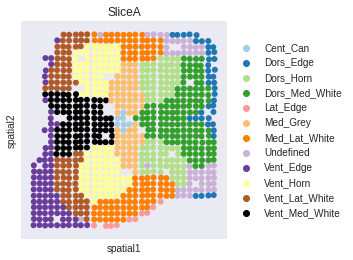

In [5]:
sc.pl.spatial(adata_c1, spot_size=1, color = ['anno'], 
              vmin = 'p1', vmax = 'p99', title = 'SliceA', 
              palette= c_pal, cmap = 'rocket_r')

... storing 'anno' as categorical


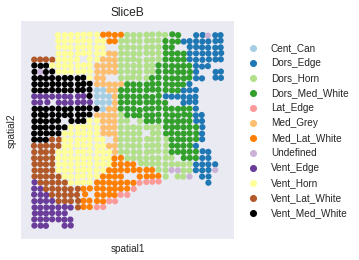

In [6]:
sc.pl.spatial(adata_c2, spot_size=1, color = ['anno'],  
              vmin = 'p1', vmax = 'p99', title = 'SliceB', 
              palette=c_pal, cmap = 'rocket_r')

#### Relabel Vent_Horn and Dors_Horn 1 and 2

Figure out the Y cutoff the to split into two groups.

/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)


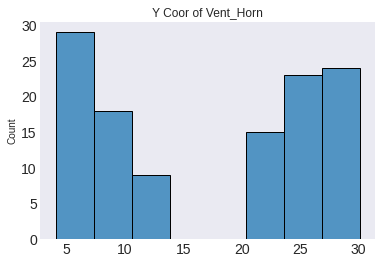

/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)


[Text(0.5, 1.0, 'Y Coor of Dors_Horn')]

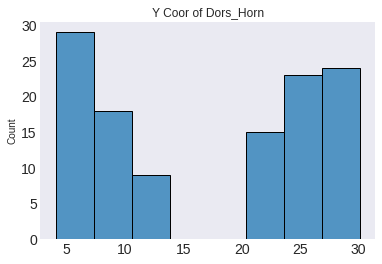

In [7]:
idx = adata_c1.obs['anno'] == 'Vent_Horn'

g = sns.histplot(adata_c1[idx, :].obsm['spatial'][:, 1])
g.set(title = 'Y Coor of Vent_Horn')
plt.show()

idx_2 = adata_c1.obs['anno'] == 'Dors_Horn'

g1 = sns.histplot(adata_c1[idx, :].obsm['spatial'][:, 1])
g1.set(title = 'Y Coor of Dors_Horn')

... storing 'anno_v2' as categorical


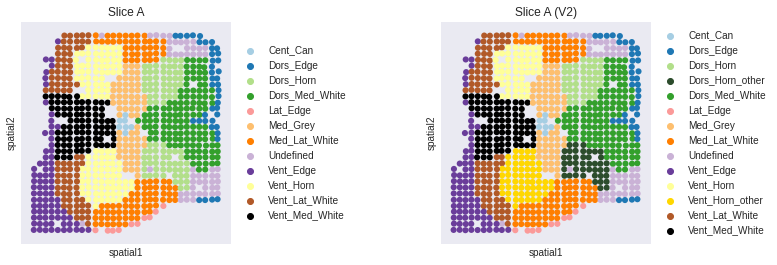

In [8]:
anno_v2 = list(adata_c1.obs['anno'])

for i in range(len(anno_v2)):
    if idx[i]:
        if adata_c1.obsm['spatial'][i, 1] > 17:
            anno_v2[i] = anno_v2[i] + '_other'
    if idx_2[i]:
        if adata_c1.obsm['spatial'][i, 1] > 17:
            anno_v2[i] = anno_v2[i] + '_other'

adata_c1.obs['anno_v2'] = anno_v2
c_pal_v2 = c_pal.copy()
c_pal_v2['Vent_Horn_other'] = '#FFD700'
c_pal_v2['Dors_Horn_other'] = '#2c4c2c'

sc.pl.spatial(adata_c1, spot_size=1, color = ['anno', 'anno_v2'], 
              vmin = 'p1', vmax = 'p99', title = ['Slice A', 'Slice A (V2)'], 
              palette= c_pal_v2, cmap = 'rocket_r')

Repeat for layer 2

/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)


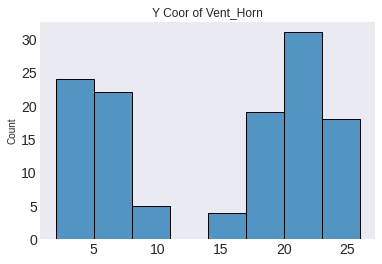

/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)


[Text(0.5, 1.0, 'Y Coor of Dors_Horn')]

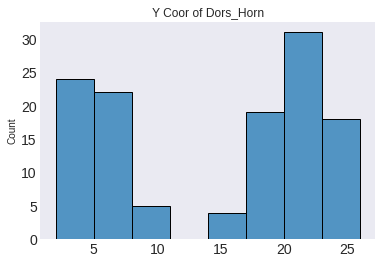

In [9]:
idx = adata_c2.obs['anno'] == 'Vent_Horn'

g = sns.histplot(adata_c2[idx, :].obsm['spatial'][:, 1])
g.set(title = 'Y Coor of Vent_Horn')
plt.show()

idx_2 = adata_c2.obs['anno'] == 'Dors_Horn'

g1 = sns.histplot(adata_c2[idx, :].obsm['spatial'][:, 1])
g1.set(title = 'Y Coor of Dors_Horn')

... storing 'anno_v2' as categorical


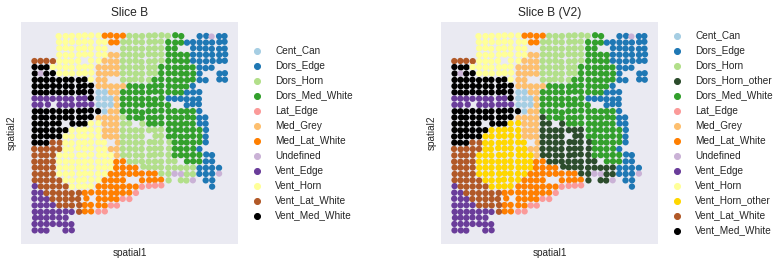

In [10]:
anno_v2 = list(adata_c2.obs['anno'])

for i in range(len(anno_v2)):
    if idx[i]:
        if adata_c2.obsm['spatial'][i, 1] > 13:
            anno_v2[i] = anno_v2[i] + '_other'
    if idx_2[i]:
        if adata_c2.obsm['spatial'][i, 1] > 13:
            anno_v2[i] = anno_v2[i] + '_other'

adata_c2.obs['anno_v2'] = anno_v2
c_pal_v2 = c_pal.copy()
c_pal_v2['Vent_Horn_other'] = '#FFD700'
c_pal_v2['Dors_Horn_other'] = '#2c4c2c'

sc.pl.spatial(adata_c2, spot_size=1, color = ['anno', 'anno_v2'], 
              vmin = 'p1', vmax = 'p99', title =  ['Slice B', 'Slice B (V2)'], 
              palette= c_pal_v2, cmap = 'rocket_r')

## Evaluate PASTE

Read in data and relabel Vent_horn and Dors_Horn as done above. Save as a function for convenience.

In [11]:
def read_in_data():
    adata_c1 = load_layer('../data/spinal/L8CN11_E1_stdata_aligned_counts_IDs.txt')
    labels_df = pd.read_csv('../data/spinal/L8CN11_E1.tsv.annotations.tsv', delimiter='\t')
    labels_df.drop(labels_df.columns[[0, 1, 2, 3]], axis=1, inplace = True)
    adata_c1.obs['anno'] = list(labels_df.idxmax(axis = 1))

    adata_c2 = load_layer('../data/spinal/L8CN11_E2_stdata_aligned_counts_IDs.txt')
    labels_df = pd.read_csv('../data/spinal/L8CN11_E2.tsv.annotations.tsv', delimiter='\t')
    labels_df.drop(labels_df.columns[[0, 1, 2, 3]], axis=1, inplace = True)
    adata_c2.obs['anno'] = list(labels_df.idxmax(axis = 1))

    idx = adata_c1.obs['anno'] == 'Vent_Horn'
    idx_2 = adata_c1.obs['anno'] == 'Dors_Horn'
    anno_v2 = list(adata_c1.obs['anno'])
    for i in range(len(anno_v2)):
        if idx[i]:
            if adata_c1.obsm['spatial'][i, 1] > 17:
                anno_v2[i] = anno_v2[i] + '_other'
        if idx_2[i]:
            if adata_c1.obsm['spatial'][i, 1] > 17:
                anno_v2[i] = anno_v2[i] + '_other'
    adata_c1.obs['anno_v2'] = anno_v2
    c_pal_v2 = c_pal.copy()
    c_pal_v2['Vent_Horn_other'] = '#FFD700'
    c_pal_v2['Dors_Horn_other'] = '#2c4c2c'

    idx = adata_c2.obs['anno'] == 'Vent_Horn'
    idx_2 = adata_c2.obs['anno'] == 'Dors_Horn'
    anno_v2 = list(adata_c2.obs['anno'])
    for i in range(len(anno_v2)):
        if idx[i]:
            if adata_c2.obsm['spatial'][i, 1] > 13:
                anno_v2[i] = anno_v2[i] + '_other'
        if idx_2[i]:
            if adata_c2.obsm['spatial'][i, 1] > 13:
                anno_v2[i] = anno_v2[i] + '_other'
    adata_c2.obs['anno_v2'] = anno_v2
    return adata_c1, adata_c2

In [12]:
annotations = np.unique(adata_c1.obs['anno'])
c_pal = dict(zip(annotations, sns.color_palette("Paired")[:len(annotations)] + ['#000000']))
c_pal_v2 = c_pal.copy()
c_pal_v2['Vent_Horn_other'] = '#FFD700'
c_pal_v2['Dors_Horn_other'] = '#2c4c2c'

Flip layer 2 vertically or horizontally

In [13]:
adata_c1, adata_c2 = read_in_data()

adata_c2_flip_vert = adata_c2.copy()
adata_c2_flip_vert.obsm['spatial'][:,1] *= -1

adata_c2_flip_horz = adata_c2.copy()
adata_c2_flip_horz.obsm['spatial'][:,0] *= -1

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Combining duplicate genes


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Combining duplicate genes


... storing 'anno' as categorical
... storing 'anno_v2' as categorical


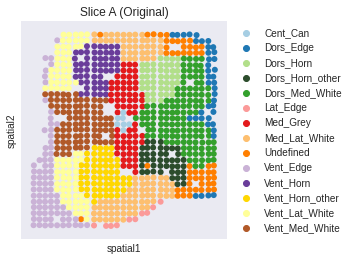

... storing 'anno' as categorical
... storing 'anno_v2' as categorical


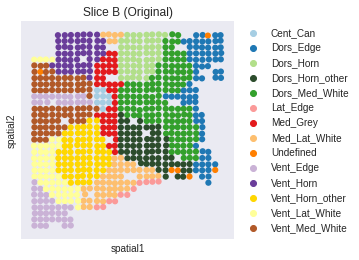

... storing 'anno' as categorical
... storing 'anno_v2' as categorical


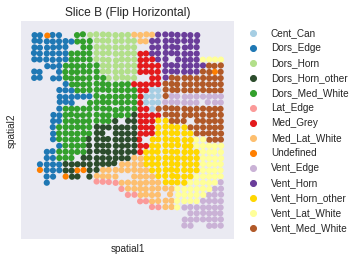

... storing 'anno' as categorical
... storing 'anno_v2' as categorical


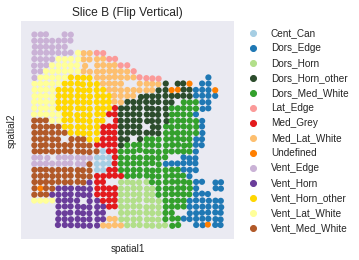

In [14]:
sc.pl.spatial(adata_c1, spot_size=1, color = ['anno_v2'],  title = 'Slice A (Original)', 
              palette=c_pal_v2, outline_color= 'black',)
sc.pl.spatial(adata_c2, spot_size=1, color = ['anno_v2'],  title = 'Slice B (Original)', 
              palette=c_pal_v2, outline_color= 'black',)
sc.pl.spatial(adata_c2_flip_horz, spot_size=1, color = ['anno_v2'],  title = 'Slice B (Flip Horizontal)', 
              palette=c_pal_v2, outline_color= 'black',)
sc.pl.spatial(adata_c2_flip_vert, spot_size=1, color = ['anno_v2'],  title = 'Slice B (Flip Vertical)', 
              palette=c_pal_v2, outline_color= 'black',)

### Calculate % of spots conserved between AARs

Simulate experiments

In [15]:
def percent_aar_conserved(adata_layer1, adata_layer2, alpha):
    adata_c1 = adata_layer1.copy()
    adata_c2 = adata_layer2.copy()
    pi = paste.pairwise_align(adata_c1, adata_c2, alpha=alpha)
    spotsA, spotsB = np.nonzero(pi)
    s = 0
    for i in range(len(spotsA)):
        # get the clusters corresponding to each spot
        a = adata_c1.obs['anno_v2'][spotsA[i]]
        b = adata_c2.obs['anno_v2'][spotsB[i]]
        if a == b:
            s += pi[spotsA[i]][spotsB[i]]
    return s

In [16]:
alphas = [0, 0.001, 0.01, 0.1, 1]
original_scores = []
horz_scores = []
vert_scores = []
for a in alphas:
    original_scores.append(percent_aar_conserved(adata_c1, adata_c2, a))
    horz_scores.append(percent_aar_conserved(adata_c1, adata_c2_flip_horz, a))
    vert_scores.append(percent_aar_conserved(adata_c1, adata_c2_flip_vert, a))

/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)


Filtered all slices for common genes. There are 16367 common genes.


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)


Filtered all slices for common genes. There are 16367 common genes.


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)


Filtered all slices for common genes. There are 16367 common genes.


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)


Filtered all slices for common genes. There are 16367 common genes.


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)


Filtered all slices for common genes. There are 16367 common genes.


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)


Filtered all slices for common genes. There are 16367 common genes.


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)


Filtered all slices for common genes. There are 16367 common genes.


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)


Filtered all slices for common genes. There are 16367 common genes.


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)


Filtered all slices for common genes. There are 16367 common genes.


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)


Filtered all slices for common genes. There are 16367 common genes.


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)


Filtered all slices for common genes. There are 16367 common genes.


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)


Filtered all slices for common genes. There are 16367 common genes.


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)


Filtered all slices for common genes. There are 16367 common genes.


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)


Filtered all slices for common genes. There are 16367 common genes.


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)


Filtered all slices for common genes. There are 16367 common genes.


In [17]:
path_to_output_dir = '../data/Spinal-Cord/cached-results/'
if not os.path.exists(path_to_output_dir):
    os.makedirs(path_to_output_dir)

In [18]:
df = pd.DataFrame([original_scores, horz_scores, vert_scores], columns = alphas, 
             index =['Original', 'Horizontal', 'Vertical']).to_csv(path_to_output_dir + 'results.csv')
df

## Plot

In [2]:
path_to_output_dir = '../data/Spinal-Cord/cached-results/'
df = pd.read_csv(path_to_output_dir + 'results.csv', index_col= 0)

In [3]:
df

,0.0,0.001,0.01,0.1,1.0
Original,0.206841,0.504324,0.555927,0.551089,0.547849
Horizontal,0.206841,0.504324,0.555927,0.551089,0.547849
Vertical,0.206841,0.504324,0.555927,0.551089,0.547849


In [4]:
vals = []
for c in df.columns:
    vals.append(df[c].values)
vals = np.concatenate(vals)

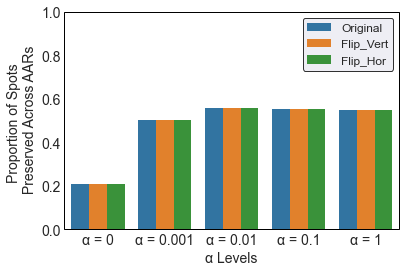

In [5]:
colors = sns.color_palette()
bar_label = 5*['Original', 'Flip_Vert', 'Flip_Hor']
labels = 3*['α = 0'] + 3*['α = 0.001'] + 3*['α = 0.01'] +3*['α = 0.1'] + 3*['α = 1']

ax = sns.barplot(x=labels, y = vals, hue=bar_label, palette=sns.color_palette(colors))
ax.set_facecolor('white')
ax.patch.set_edgecolor('black')
ax.patch.set_linewidth('1')
ax.set(ylim = (0, 1))
ax.set_ylabel("Proportion of Spots \n Preserved Across AARs", fontsize = 14)
ax.set_xlabel("α Levels", fontsize = 14)
ax.grid(False)
plt.legend(frameon=True, edgecolor='black', fontsize = 12)
# plt.savefig('spinal_pairwise_plot.pdf', dpi = 300, bbox_inches = "tight")